# Ray RLlib Multi-Armed Bandits - Linear Thompson Sampling

© 2019-2020, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademy_Logo_clearbanner_141x100.png)

This lesson explore o using **Linear Thompson Sampling** on the `WheelBandit` environment.
Finally, let’s explore another contextual bandit based on the Linear Thompson Sampling (LinTS) exploration strategy. For detailed discussion about the algorithm see:

For more information about `WheelBandit` see https://arxiv.org/abs/1802.09127

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ray import tune
from ray.rllib.contrib.bandits.agents import LinTSTrainer
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG
from ray.rllib.contrib.bandits.envs import WheelBanditEnv

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


The effective number of `training_iterations` will be `20 * timesteps_per_iteration == 2,000` where the timesteps per iteration is `100` by default.

In [2]:
TS_CONFIG["env"] = WheelBanditEnv

training_iterations = 20
print("Running training for %s time steps" % training_iterations)

Running training for 20 time steps


In [3]:
print(TS_CONFIG)

{'num_workers': 0, 'num_envs_per_worker': 1, 'rollout_fragment_length': 1, 'sample_batch_size': -1, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 1, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}, 'custom_preprocessor': None}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': <class 'ray.rllib.contrib.bandits.envs.discrete.WheelBanditEnv'>, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 0.0001, 'monitor': False, 'log_level': 'WARN',

In [66]:
start_time = time.time()

analysis = tune.run(
    LinTSTrainer,
    config=TS_CONFIG,
    stop={"training_iteration": training_iterations},
    num_samples=2,
    checkpoint_at_end=True
    )

print("The trials took", time.time() - start_time, "seconds\n")

Trial name,status,loc
LinTS_WheelBanditEnv_00000,RUNNING,
LinTS_WheelBanditEnv_00001,PENDING,


(pid=89483) 2020-05-17 14:27:16,341	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=89483) 2020-05-17 14:27:16,342	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=89483) /opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=89483)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=89483) 2020-05-17 14:27:16,350	INFO trainable.py:217 -- Getting current IP.
(pid=89483) 2020-05-17 14:27:16,350	WARNING util.py:37 -- Install gputil for GPU system monitoring.
Result for LinTS_WheelBanditEnv_00000:
  custom_metrics: {}
  date: 2020-05-17_14-27-16
  done: false
  episode_len_mean: 1.0
  episode_reward_max: 50.02331449169518
  episode_reward_mean: 30.893651527165694
  episode_reward_min: 0.9773324038321672
  episodes_this_iter: 100
  episodes_to

Trial name,status,loc,iter,total time (s),ts,reward
LinTS_WheelBanditEnv_00000,RUNNING,192.168.1.244:89483,11,1.82232,1100,38.7308
LinTS_WheelBanditEnv_00001,RUNNING,192.168.1.244:89531,8,1.33611,800,35.7915


Result for LinTS_WheelBanditEnv_00000:
  custom_metrics: {}
  date: 2020-05-17_14-27-19
  done: true
  episode_len_mean: 1.0
  episode_reward_max: 50.02980941361751
  episode_reward_mean: 38.24052000377522
  episode_reward_min: 0.976267798700682
  episodes_this_iter: 100
  episodes_total: 2000
  experiment_id: 7639cc0791d74af98bbe0ac6e9d23966
  experiment_tag: '0'
  grad_time_ms: 0.452
  hostname: derwen
  info:
    grad_time_ms: 0.452
    learner:
      cumulative_regret: 1817.806782027969
      update_latency: 0.0003600120544433594
    num_steps_sampled: 2000
    num_steps_trained: 2000
    opt_peak_throughput: 2209.971
    opt_samples: 1.0
    sample_peak_throughput: 865.251
    sample_time_ms: 1.156
    update_time_ms: 0.002
  iterations_since_restore: 20
  learner:
    cumulative_regret: 1817.806782027969
    update_latency: 0.0003600120544433594
  node_ip: 192.168.1.244
  num_healthy_workers: 0
  num_steps_sampled: 2000
  num_steps_trained: 2000
  off_policy_estimator: {}
  opt_p

Trial name,status,loc,iter,total time (s),ts,reward
LinTS_WheelBanditEnv_00000,TERMINATED,,20,3.26338,2000,38.2405
LinTS_WheelBanditEnv_00001,TERMINATED,,20,3.27749,2000,34.3201


The trials took 7.234298944473267 seconds



Analyze cumulative regrets of the trials

In [67]:
df = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df = df.append(df_trial, ignore_index=True)

regrets = df \
    .groupby("num_steps_trained")["learner/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

Text(0.5, 0, 'Training steps')

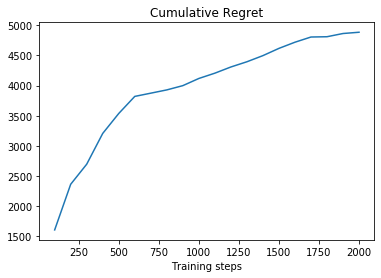

In [68]:
fig, ax = plt.subplots()

ax.plot(regrets["mean"])
ax.set_title("Cumulative Regret")
ax.set_xlabel("Training steps")

Restore trainer from checkpoint

In [69]:
trial = analysis.trials[0]
trainer = LinTSTrainer(config=TS_CONFIG)
trainer.restore(trial.checkpoint.value)

2020-05-17 14:27:46,768	INFO trainable.py:217 -- Getting current IP.
2020-05-17 14:27:46,770	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-05-17 14:27:46,772	INFO trainable.py:217 -- Getting current IP.
2020-05-17 14:27:46,773	INFO trainable.py:423 -- Restored on 192.168.1.244 from checkpoint: /Users/paco/ray_results/LinTS/LinTS_WheelBanditEnv_0_2020-05-17_14-27-13jahzdubk/checkpoint_20/checkpoint-20
2020-05-17 14:27:46,775	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 2000, '_time_total': 3.2633776664733887, '_episodes_total': 2000}


Get model to plot arm weights distribution

In [70]:
model = trainer.get_policy().model
means = [model.arms[i].theta.numpy() for i in range(5)]
covs = [model.arms[i].covariance.numpy() for i in range(5)]

Plot weight distributions for different arms

In [71]:
def plot_model_weights (means, covs, ax):
    fmts = ["bo", "ro", "yx", "k+", "gx"]
    labels = ["arm{}".format(i) for i in range(5)]

    ax.set_title("Weights distributions of arms")

    for i in range(0, 5):
        x, y = np.random.multivariate_normal(means[i] / 30, covs[i], 5000).T
        ax.plot(x, y, fmts[i], label=labels[i])

    ax.set_aspect("equal")
    ax.grid(True, which="both")
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.legend(loc="best")

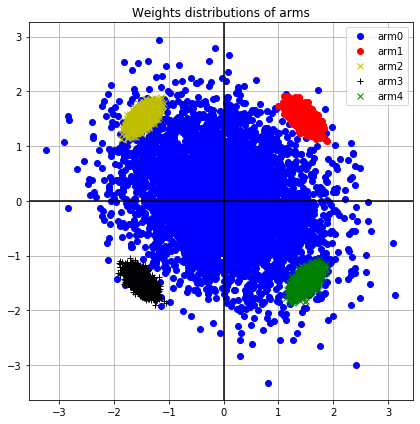

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_model_weights(means, covs, ax)

fig.tight_layout()
plt.show()